# Lesson 6: Essay Writer

<p align="center">
  <img src="imgs/essay_writer.png" alt="Essay Writer">
</p>

In [2]:
from dotenv import load_dotenv

_ = load_dotenv()

In [14]:
import os
import operator
from typing import TypedDict, Annotated, List

from tavily import TavilyClient

from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
)
from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

In [15]:
memory = SqliteSaver.from_conn_string(":memory:")
model = ChatAnthropic(model_name="claude-3-5-sonnet-20240620")
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [5]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [9]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [10]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [11]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [12]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [13]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [16]:
class Queries(BaseModel):
    queries: List[str]

In [17]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [18]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [19]:
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [20]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [21]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [22]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [23]:
builder = StateGraph(AgentState)

In [24]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [25]:
builder.set_entry_point("planner")

In [27]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [28]:
graph = builder.compile(checkpointer=memory)

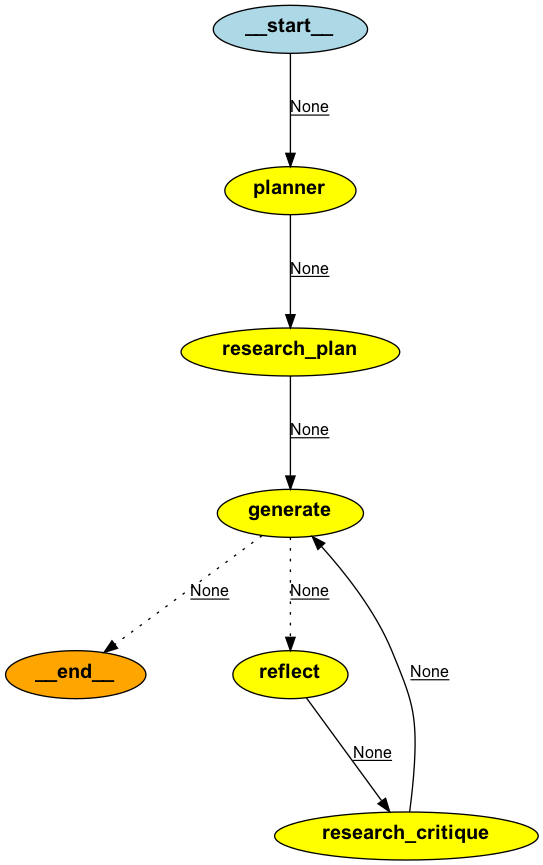

In [29]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [30]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(
    {
        "task": "what is the difference between langchain and langsmith",
        "max_revisions": 2,
        "revision_number": 1,
    },
    thread,
):
    print(s)

{'planner': {'plan': "Here's a high-level outline for an essay on the difference between LangChain and LangSmith:\n\nTitle: LangChain vs. LangSmith: Understanding the Distinction in AI Development Tools\n\nI. Introduction\n   A. Brief overview of AI and language model development\n   B. Importance of tools in the AI ecosystem\n   C. Thesis statement: While LangChain and LangSmith are both valuable tools in AI development, they serve distinct purposes and offer different functionalities.\n\nII. LangChain: An Open-Source Framework\n    A. Definition and purpose\n    B. Key features and capabilities\n    C. Use cases and applications\n\nIII. LangSmith: A Debugging and Monitoring Platform\n     A. Definition and purpose\n     B. Key features and capabilities\n     C. Use cases and applications\n\nIV. Comparing LangChain and LangSmith\n    A. Primary differences in functionality\n    B. Target users and use cases\n    C. How they complement each other in the development process\n\nV. The Sy